# 用户画像-案例


### 基于用户搜索关键词数据为用户打上标签（年龄，性别，学历）

## 整体流程
<img src="./img/1.png" alt="FAO" width="500" align="right">
### （一）数据预处理
* 编码方式转换
* 对数据搜索内容进行分词
* 词性过滤
* 数据检查

### （二）特征选择
* 建立word2vec词向量模型
* 对所有搜索数据求平均向量

### （三）建模预测
* 不同机器学习模型对比
* 堆叠模型

### 将原始数据转换成utf-8编码，防止后续出现各种编码问题
由于原始数据比较大，在分词与过滤阶段会比较慢，这里我们选择了原始数据中的1W个

In [6]:
import csv

#原始数据存储路径
data_path = './data/user_tag_query.10W.TRAIN' 
#生成数据路径
csvfile = open(data_path + '-1w.csv', 'w')
writer = csv.writer(csvfile)
writer.writerow(['ID', 'age', 'Gender', 'Education', 'QueryList'])
#转换成utf-8编码的格式
with open(data_path, 'r',encoding='gb18030',errors='ignore') as f:
    lines = f.readlines()
    for line in lines[0:10000]:
        try:
            line.strip()          
            data = line.split("\t")
            writedata = [data[0], data[1], data[2], data[3]]
            querystr = ''
            data[-1]=data[-1][:-1]
            for d in data[4:]:
                try:
                    cur_str = d.encode('utf8')
                    cur_str = cur_str.decode('utf8')
                    querystr += cur_str + '\t'
                except:
                    continue
                    #print (data[0][0:10])
            querystr = querystr[:-1]
            writedata.append(querystr)
            writer.writerow(writedata)
        except:
            #print (data[0][0:20])
            continue

测试集的编码转换方式同上

In [9]:
data_path = './data/user_tag_query.10W.TEST'

csvfile = open(data_path + '-1w.csv', 'w')
writer = csv.writer(csvfile)
writer.writerow(['ID', 'QueryList'])
with open(data_path, 'r',encoding='gb18030',errors='ignore') as f:
    lines = f.readlines()
    for line in lines[0:10000]:
        try:
            data = line.split("\t")
            writedata = [data[0]]
            querystr = ''
            data[-1]=data[-1][:-1]
            for d in data[1:]:
                try:                  
                    cur_str = d.encode('utf8')
                    cur_str = cur_str.decode('utf8')
                    querystr += cur_str + '\t'               
                except:
                    #print (data[0][0:10])
                    continue
            querystr = querystr[:-1]
            writedata.append(querystr)
            writer.writerow(writedata)
        except:
            #print (data[0][0:20])
            continue

### 生成对应的数据表

In [56]:
import pandas as pd

#编码转换完成的数据，取的是1W的子集
trainname = './data/user_tag_query.10W.TRAIN-1w.csv'
testname = './data/user_tag_query.10W.TEST-1w.csv'

data = pd.read_csv(trainname,encoding='gbk')
print (data.info())

#分别生成三种标签数据（性别，年龄，学历）
data.age.to_csv("./data/train_age.csv", index=False)
data.Gender.to_csv("./data/train_gender.csv", index=False)
data.Education.to_csv("./data/train_education.csv", index=False)
#将搜索数据单独拿出来
data.QueryList.to_csv("./data/train_querylist.csv", index=False)

data = pd.read_csv(testname,encoding='gbk')
print (data.info())

data.QueryList.to_csv("./data/test_querylist.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9988 entries, 0 to 9987
Data columns (total 5 columns):
ID           9988 non-null object
age          9988 non-null int64
Gender       9988 non-null int64
Education    9988 non-null int64
QueryList    9988 non-null object
dtypes: int64(3), object(2)
memory usage: 390.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9979 entries, 0 to 9978
Data columns (total 2 columns):
ID           9979 non-null object
QueryList    9979 non-null object
dtypes: object(2)
memory usage: 156.0+ KB
None


### 对用户的搜索数据进行分词与词性过滤
这里需要分别对训练集和测试集进行相同的操作，路径名字要改动一下

In [14]:
import pandas as pd
import jieba.analyse
import time
import jieba
import jieba.posseg
import os, sys


def input(trainname):
    traindata = []
    with open(trainname, 'rb') as f:
        line = f.readline()
        count = 0
        while line:
            try:
                traindata.append(line)
                count += 1
            except:
                print ("error:", line, count)
            line=f.readline()
    return traindata
start = time.clock()

filepath = './data/test_querylist.csv'
QueryList = input(filepath)

writepath = './data/test_querylist_writefile-1w.csv'
csvfile = open(writepath, 'w')

POS = {}
for i in range(len(QueryList)):
    #print (i)
    if i%2000 == 0 and i >=1000:
        print (i,'finished') 
    s = []
    str = ""
    words = jieba.posseg.cut(QueryList[i])# 带有词性的精确分词模式
    allowPOS = ['n','v','j']
    for word, flag in words:
        POS[flag]=POS.get(flag,0)+1
        if (flag[0] in allowPOS) and len(word)>=2:
            str += word + " "
            
    cur_str = str.encode('utf8')
    cur_str = cur_str.decode('utf8')
    s.append(cur_str)
    
    csvfile.write(" ".join(s)+'\n')
csvfile.close()

end = time.clock()
print ("total time: %f s" % (end - start))

2000 finished
4000 finished
6000 finished
8000 finished
total time: 880.971740 s


### 使用Gensim库建立word2vec词向量模型
### 参数定义：
-  sentences：可以是一个list
-  sg： 用于设置训练算法，默认为0，对应CBOW算法；sg=1则采用skip-gram算法。
-  size：是指特征向量的维度，默认为100。大的size需要更多的训练数据,但是效果会更好. 推荐值为几十到几百。
-  window：表示当前词与预测词在一个句子中的最大距离是多少
-  alpha: 是学习速率
-  seed：用于随机数发生器。与初始化词向量有关。
-  min_count: 可以对字典做截断. 词频少于min_count次数的单词会被丢弃掉, 默认值为5
-  max_vocab_size: 设置词向量构建期间的RAM限制。如果所有独立单词个数超过这个，则就消除掉其中最不频繁的一个。每一千万个单词需要大约1GB的RAM。设置成None则没有限制。

-  workers参数控制训练的并行数。
-  hs: 如果为1则会采用hierarchica·softmax技巧。如果设置为0（defau·t），则negative sampling会被使用。
-  negative: 如果>0,则会采用negativesamp·ing，用于设置多少个noise words
-  iter： 迭代次数，默认为5

In [20]:
from gensim.models import word2vec
#将数据变换成list of list格式
train_path = './data/train_querylist_writefile-1w.csv'
with open(train_path, 'r') as f:
    My_list = []
    lines = f.readlines()
    for line in lines:
        cur_list = []
        line = line.strip()
        data = line.split(" ")
        for d in data:
            cur_list.append(d)
        My_list.append(cur_list)
    
    model = word2vec.Word2Vec(My_list, size=300, window=10,workers=4)  
    savepath = '1w_word2vec_' + '300'+'.model' # 保存model的路径

    model.save(savepath)

In [27]:
model.most_similar("大哥")

[('风雹', 0.8893747329711914),
 ('龙组', 0.8870506882667542),
 ('受欢迎', 0.8759890198707581),
 ('皮特', 0.8737666606903076),
 ('民调', 0.8706102967262268),
 ('许文强', 0.8705775141716003),
 ('黑老大', 0.8696860671043396),
 ('乞丐', 0.8689215779304504),
 ('圣域', 0.8689209818840027),
 ('群英', 0.8688154220581055)]

In [31]:
model.most_similar("清华")

[('北京大学', 0.9314329028129578),
 ('委员', 0.9181340932846069),
 ('特长生', 0.9098962545394897),
 ('中国人民大学', 0.9066182374954224),
 ('北大', 0.9033325910568237),
 ('清华大学', 0.9025564789772034),
 ('工作部', 0.8978621363639832),
 ('复旦大学', 0.8967786431312561),
 ('金融学', 0.8937995433807373),
 ('投档', 0.8907859325408936)]

### 加载训练好的word2vec模型，求用户搜索结果的平均向量

In [34]:
import numpy as np
file_name = './data/train_querylist_writefile-1w.csv'
cur_model = gensim.models.Word2Vec.load('1w_word2vec_300.model')
with open(file_name, 'r') as f:
    cur_index = 0
    lines = f.readlines()
    doc_cev = np.zeros((len(lines),300))
    for line in lines:
        word_vec = np.zeros((1,300))
        words = line.strip().split(' ')
        wrod_num = 0
        #求模型的平均向量
        for word in words:
            if word in cur_model:
                wrod_num += 1
                word_vec += np.array([cur_model[word]])
        doc_cev[cur_index] = word_vec / float(wrod_num)
        cur_index += 1

In [35]:
doc_cev.shape

(9988, 300)

In [36]:
doc_cev[5]

array([-0.32963576,  0.09165895,  0.37035566,  0.15858265, -0.25632772,
        0.46823607,  0.08479289, -0.09562777, -0.48537965, -0.04363835,
        0.48571603,  0.1187871 , -0.19456722,  0.20186944,  0.30645476,
        0.01102684, -0.04478108,  0.20113739, -0.08005867, -0.95247635,
       -0.01227955,  0.00696389, -0.3039621 ,  0.61217366,  0.21240715,
        0.14640459, -0.21849218, -0.84263162,  0.52864702, -0.40276359,
       -0.36570598,  0.10162218,  0.25552753, -0.2048686 ,  0.2416216 ,
       -0.18987446, -0.00617808,  0.21611415,  0.43024731, -0.36179712,
       -0.4873151 , -0.33222837, -0.09125527,  0.39969577,  0.3087728 ,
       -0.13975002, -0.00378791,  0.0189908 , -0.16623354,  0.05266528,
        0.29755896, -0.38497848,  0.43066086,  0.10289612, -0.71760135,
       -0.40782765, -0.4868693 , -0.16743555,  0.15261012, -0.2065284 ,
        0.32500373,  0.20506871,  0.11342901,  0.26840977, -0.11748349,
       -0.94276241, -0.10549763,  0.23851692,  0.03458147, -0.04

In [37]:
genderlabel = np.loadtxt(open('./data/train_gender.csv', 'r')).astype(int)
genderlabel.shape

(9988,)

In [39]:
educationlabel = np.loadtxt(open('./data/train_education.csv', 'r')).astype(int)
educationlabel.shape

(9988,)

In [40]:
agelabel = np.loadtxt(open('./data/train_age.csv', 'r')).astype(int)
agelabel.shape

(9988,)

In [41]:
def removezero(x, y):
        nozero = np.nonzero(y)
        y = y[nozero]
        x = np.array(x)
        x = x[nozero]
        return x, y
gender_train, genderlabel = removezero(doc_cev, genderlabel)
age_train, agelabel = removezero(doc_cev, agelabel)
education_train, educationlabel = removezero(doc_cev, educationlabel)
print (gender_train.shape,genderlabel.shape)
print (age_train.shape,agelabel.shape)
print (education_train.shape,educationlabel.shape)

(9756, 300) (9756,)
(9815, 300) (9815,)
(9064, 300) (9064,)


### 绘图函数，以性别为例，绘制混淆矩阵

In [42]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 测试集的构造方法和训练集一样

In [44]:
import numpy as np
file_name = './data/test_querylist_writefile-1w.csv'
cur_model = gensim.models.Word2Vec.load('1w_word2vec_300.model')
with open(file_name, 'r') as f:
    cur_index = 0
    lines = f.readlines()
    doc_cev = np.zeros((len(lines),300))
    for line in lines:
        word_vec = np.zeros((1,300))
        words = line.strip().split(' ')
        wrod_num = 0
        #求模型的平均向量
        for word in words:
            if word in cur_model:
                wrod_num += 1
                word_vec += np.array([cur_model[word]])
        doc_cev[cur_index] = word_vec / float(wrod_num)
        cur_index += 1

### 检查一下数据有木有问题

In [45]:
doc_cev.shape

(9979, 300)

In [86]:
doc_cev[6]

array([ -1.40948582e-01,  -7.83803609e-02,   2.15763443e-01,
         1.37518199e-01,   2.30699531e-01,  -3.89948267e-02,
        -1.31107922e-01,  -3.12056526e-01,  -4.11792463e-01,
         5.50757989e-01,   6.35229338e-02,   1.02547314e-01,
        -3.52964044e-02,   6.36397276e-02,   7.96098084e-02,
         3.74873843e-01,   1.10930597e-01,   3.76115695e-01,
        -6.18163756e-01,  -4.65835745e-01,   1.80290355e-02,
         7.01652931e-02,  -9.72175971e-02,   2.64578183e-01,
         2.51769353e-01,  -3.53601411e-02,  -1.43570983e-01,
        -3.18113600e-01,   1.44785517e-01,  -2.82206427e-01,
        -5.70270152e-02,  -1.97119162e-01,   1.74863956e-01,
         2.87672050e-01,  -4.30430668e-02,   1.57361957e-02,
         1.49231222e-01,   5.42560797e-02,  -7.76399297e-02,
         1.64214515e-01,   1.20145906e-01,  -2.70355637e-01,
        -1.77872375e-01,  -1.96268085e-01,   1.17089703e-01,
        -1.33172379e-01,   3.49030844e-01,  -3.22540690e-01,
         3.97371212e-01,

### 建立一个基础预测模型

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.798155737705
Recall metric in the testing dataset:  0.735074626866
accuracy metric in the testing dataset:  0.798155737705


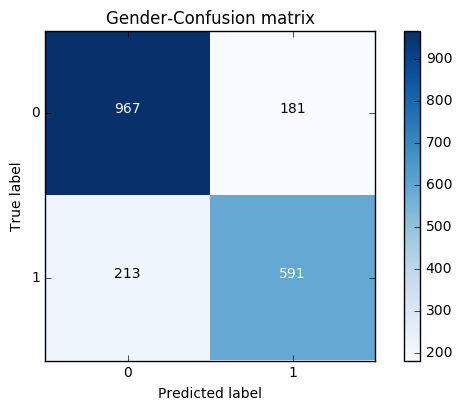

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gender_train,genderlabel,test_size = 0.2, random_state = 0)

LR_model = LogisticRegression()

LR_model.fit(X_train,y_train)
y_pred = LR_model.predict(X_test)
print (LR_model.score(X_test,y_test))

cnf_matrix = confusion_matrix(y_test,y_pred)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

print("accuracy metric in the testing dataset: ", (cnf_matrix[1,1]+cnf_matrix[0,0])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[1,0]+cnf_matrix[0,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Gender-Confusion matrix')
plt.show()

0.795081967213
Recall metric in the testing dataset:  0.730099502488
accuracy metric in the testing dataset:  0.795081967213


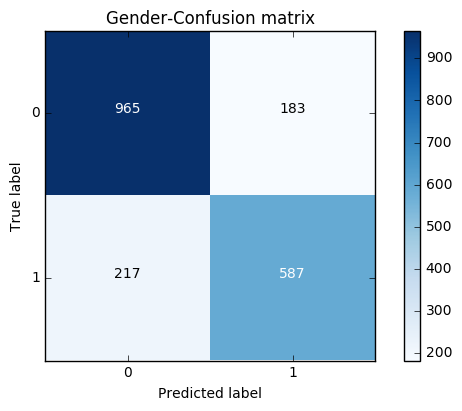

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(gender_train,genderlabel,test_size = 0.2, random_state = 0)

RF_model = RandomForestClassifier(n_estimators=100,min_samples_split=5,max_depth=10)

RF_model.fit(X_train,y_train)
y_pred = RF_model.predict(X_test)
print (RF_model.score(X_test,y_test))

cnf_matrix = confusion_matrix(y_test,y_pred)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

print("accuracy metric in the testing dataset: ", (cnf_matrix[1,1]+cnf_matrix[0,0])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[1,0]+cnf_matrix[0,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Gender-Confusion matrix')
plt.show()

### 堆叠模型
<img src="./img/2.png" alt="FAO" width="700" >

In [74]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
clf1 = RandomForestClassifier(n_estimators=100,min_samples_split=5,max_depth=10)
clf2 = SVC()
clf3 = LogisticRegression()
basemodes = [
            ['rf', clf1],
            ['svm', clf2],
            ['lr', clf3]
            ]

In [84]:
from sklearn.cross_validation import KFold, StratifiedKFold
models = basemodes

#X_train, X_test, y_train, y_test

folds = list(KFold(len(y_train), n_folds=5, random_state=0))
print (len(folds))
S_train = np.zeros((X_train.shape[0], len(models)))
S_test = np.zeros((X_test.shape[0], len(models)))

for i, bm in enumerate(models):
    clf = bm[1]

    #S_test_i = np.zeros((y_test.shape[0], len(folds)))
    for j, (train_idx, test_idx) in enumerate(folds):
        X_train_cv = X_train[train_idx]
        y_train_cv = y_train[train_idx]
        X_val = X_train[test_idx]
        clf.fit(X_train_cv, y_train_cv)
        y_val = clf.predict(X_val)[:]
          
        S_train[test_idx, i] = y_val
    S_test[:,i] = clf.predict(X_test)

final_clf = RandomForestClassifier(n_estimators=100)
final_clf.fit(S_train,y_train)

print (final_clf.score(S_test,y_test))


5
0.796106557377


array([ 1.,  1.,  2.])